## Comparing $\sigma$ - Appendix A

In [1]:
# NumCosmo

from numcosmo_py import Nc, Ncm
from numcosmo_py.ccl.nc_ccl import create_nc_obj

# CCL

import pyccl as ccl

# Colossus

from colossus.cosmology import cosmology
from colossus.halo import concentration
from colossus.lss import peaks
from colossus.utils import constants

import sys
import numpy as np
import math
import matplotlib.pyplot as plt

Set Cosmology

In [2]:
Omega_c = 0.2588
Omega_b = 0.0483
Omega_k = 0.0
H0 = 67.77
Tcmb0 = 2.7255
A_s = 2.1e-9
sigma8 = 0.8288
n_s = 0.96
Neff = 0.0
w0 = -1.0
wa = 0.0

In [3]:
# Colossus Cosmology
params=dict(H0 = H0, Om0 = (Omega_c+Omega_b), Ob0 = Omega_b, Tcmb0 = Tcmb0, Neff = Neff, sigma8 = sigma8, ns = n_s, w0=w0, wa=wa)
cosmo_col = cosmology.setCosmology("mycosmo", params)
cosmology.setCurrent(cosmo_col)

# CCL Cosmology
ccl_cosmo = ccl.Cosmology(
    Omega_c=Omega_c,
    Omega_b=Omega_b,
    Neff=Neff,
    h=H0/100.0,
    sigma8=sigma8,
    n_s=n_s,
    Omega_k=Omega_k,
    w0=w0,
    wa=wa,
    T_CMB=Tcmb0,
    m_nu=[0.00, 0.0, 0.0],
    transfer_function="eisenstein_hu",
    matter_power_spectrum="linear",
)

# NumCosmo Cosmology
Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())
nc_cosmo = create_nc_obj(ccl_cosmo)
cosmo = nc_cosmo.cosmo
psf = nc_cosmo.psf
dist = nc_cosmo.dist
multf = Nc.MultiplicityFuncWatson.new()
hmfunc = Nc.HaloMassFunction.new (dist, psf, multf)
hmfunc.prepare(cosmo) 

In [4]:
def cmp_double(desc, m1, m2, x1, x2):
    print(
        "%s: %s = % 22.15g, %s = % 22.15g, CMP: %9.2e"
        % (desc, m1, x1, m2, x2, math.fabs(x1 / x2 - 1.0))
    )

In [5]:
M = 1e13
z = 0.0
a = 1.0 / (1.0 + z)
M_col = M * cosmo.h()
M_array = 10**np.linspace(10, 15, 100)
M_col_array = M_array * cosmo.h()
z_array = np.linspace(0.0, 5.0, 100)

Define Sigma

In [6]:
# NumCosmo
m_r = hmfunc.lnM_to_lnR(cosmo, math.log(M))
R = math.exp(m_r)
sigma_nc = psf.eval_sigma(z, R)

# Colossus
nu = peaks.peakHeight(M_col, z)
sigma_col = constants.DELTA_COLLAPSE / nu

# CCL
sigma_ccl = ccl_cosmo.sigmaM(M, a)

In [7]:
cmp_double("Sigma", "NumCosmo", "CCL", sigma_nc, sigma_ccl)
cmp_double("Sigma", "NumCosmo", "COL", sigma_nc, sigma_col)
cmp_double("Sigma", "COL     ", "CCL", sigma_col, sigma_ccl)

Sigma: NumCosmo =       1.58019246105953, CCL =       1.58019302123231, CMP:  3.54e-07
Sigma: NumCosmo =       1.58019246105953, COL =       1.58021775877452, CMP:  1.60e-05
Sigma: COL      =       1.58021775877452, CCL =       1.58019302123231, CMP:  1.57e-05


Varying mass

In [8]:
# NumCosmo
sigma_ncm = np.array([])
for i in M_array:
    m_r = hmfunc.lnM_to_lnR(cosmo, math.log(i))
    R = math.exp(m_r)
    s_ncm = psf.eval_sigma(z, R)
    sigma_ncm = np.append(sigma_ncm, s_ncm)

#Colossus
nu_a = peaks.peakHeight(M_col_array, z)
sigma_colm = constants.DELTA_COLLAPSE / nu_a

#CCL
sigma_cclm = ccl_cosmo.sigmaM(M_array, a)

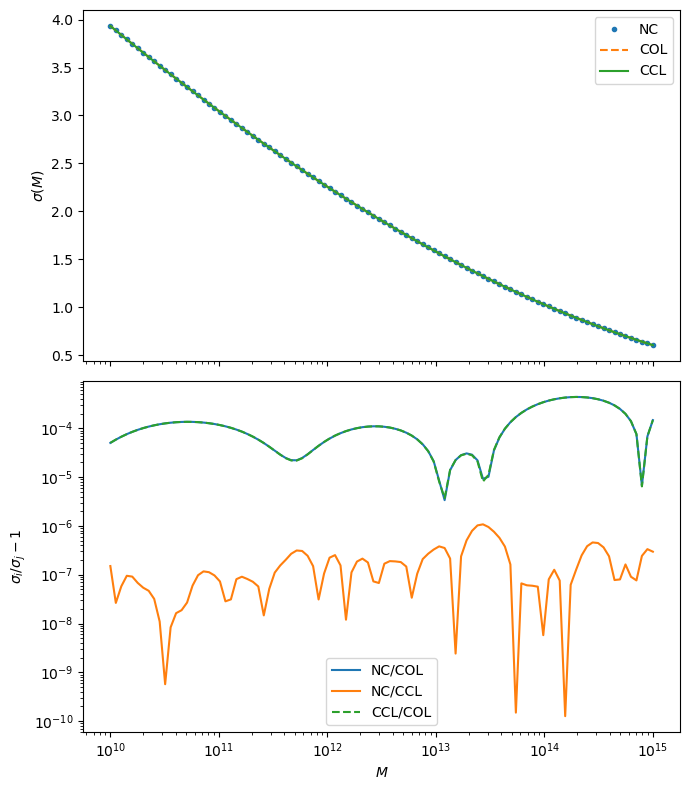

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

axs[0].set_xscale("log")
axs[0].set_ylabel(r"$\sigma(M)$")
axs[0].plot(M_array, sigma_ncm, ".", label="NC")
axs[0].plot(M_array, sigma_colm, "--", label="COL")
axs[0].plot(M_array, sigma_cclm, label="CCL")
axs[0].legend(loc="best")

axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$M$")
axs[1].set_ylabel(r"$\sigma_i/\sigma_j - 1$")
axs[1].plot(M_array, np.abs(sigma_ncm/sigma_colm - 1), label="NC/COL")
axs[1].plot(M_array, np.abs(sigma_ncm/sigma_cclm - 1), label="NC/CCL")
axs[1].plot(M_array, np.abs(sigma_cclm/sigma_colm - 1), "--", label="CCL/COL")
axs[1].legend(loc="best")

plt.tight_layout()
plt.show()

Varying redshift

In [10]:
# NumCosmo and CCL

sigma_ncz = np.array([])
sigma_cclz = np.array([])
for i in z_array:
    m_r = hmfunc.lnM_to_lnR(cosmo, math.log(M))
    R = math.exp(m_r)
    s_ncz = psf.eval_sigma(i, R)
    sigma_ncz = np.append(sigma_ncz, s_ncz)
    s_cclz = ccl_cosmo.sigmaM(M, 1.0 / (1.0 + i))
    sigma_cclz = np.append(sigma_cclz, s_cclz)

# Colossus

nu_a = peaks.peakHeight(M_col, z_array)
sigma_colz = constants.DELTA_COLLAPSE / nu_a

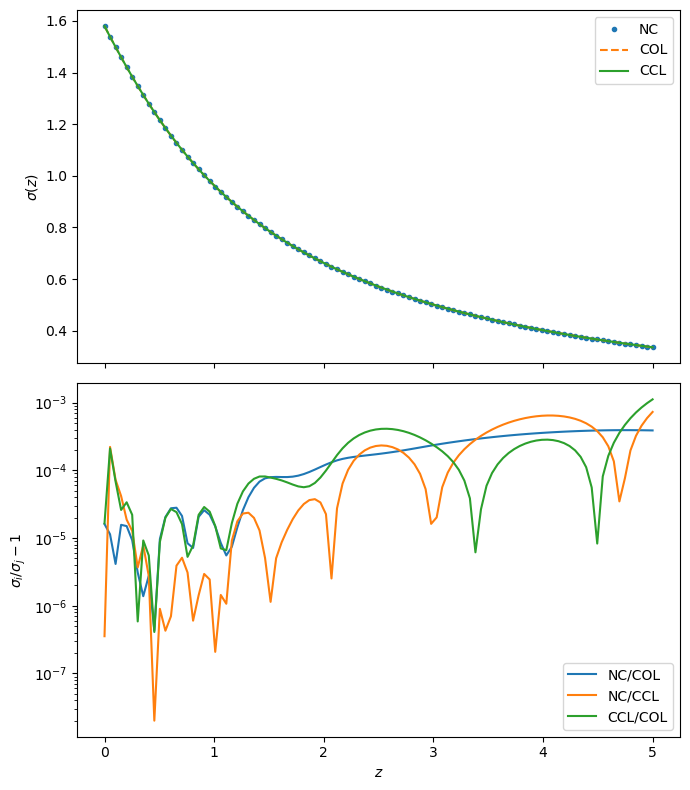

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

#axs[0].set_xscale("log")
axs[0].set_ylabel(r"$\sigma(z)$")
axs[0].plot(z_array, sigma_ncz, ".", label="NC")
axs[0].plot(z_array, sigma_colz, "--", label="COL")
axs[0].plot(z_array, sigma_cclz, label="CCL")
axs[0].legend(loc="best")

axs[1].set_yscale("log")
axs[1].set_xlabel(r"$z$")
axs[1].set_ylabel(r"$\sigma_i / \sigma_j - 1$")
axs[1].plot(z_array, np.abs(sigma_ncz/sigma_colz - 1), label="NC/COL")
axs[1].plot(z_array, np.abs(sigma_ncz/sigma_cclz - 1), label="NC/CCL")
axs[1].plot(z_array, np.abs(sigma_cclz/sigma_colz - 1), label="CCL/COL")
axs[1].legend(loc="best")

plt.tight_layout()
plt.show()